# Dataset Exploration

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from copy import deepcopy
from rich import inspect
from tqdm import tqdm

# torch
import torch

# monai
import monai
from monai.data import ImageDataset, ThreadDataLoader

# sys path append
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))


In [2]:
# rtk
from rtk import repl
from rtk.config import (
    set_hydra_configuration,
    Configuration,
    DatasetConfiguration,
    JobConfiguration,
)
from rtk.utils import login, hydra_instantiate

Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.scriptrun = azureml.core.script_run:ScriptRun._from_run_dto with exception (azure-mgmt-authorization 4.0.0 (/home/nicoleg/anaconda3/envs/ttk-env/lib/python3.11/site-packages), Requirement.parse('azure-mgmt-authorization<4,>=0.40.0')).


In [3]:
repl.install(show_locals=False)
monai.config.print_config()

MONAI version: 1.2.0
Numpy version: 1.23.5
Pytorch version: 2.0.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: /home/nicoleg/anaconda3/envs/ttk-env/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.12
ITK version: 5.3.0
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 10.0.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.15.2+cu117
tqdm version: 4.65.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.0.3
einops version: 0.6.1
transformers version: 4.33.3
mlflow version: 2.6.0
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.h

### Constant setup

In [4]:
# configs
config_name = "tests"
config_path = "../configs/"
config_dir = os.path.abspath(config_path)


In [5]:
cfg: Configuration = set_hydra_configuration(
        config_name=config_name,
        init_method_kwargs={"config_dir": config_dir},
        ConfigurationInstance=Configuration,
    )
dataset_cfg: DatasetConfiguration = cfg.datasets
job_cfg: JobConfiguration = cfg.job
monai.utils.set_determinism(seed=job_cfg.random_state)
cfg

[13:46:41] INFO     rtk.config: Creating configuration: 'tests'                                       ]8;id=790903;file:///home/nicoleg/workspaces/teddytoolkit/rtk/config.py\config.py]8;;\:]8;id=963389;file:///home/nicoleg/workspaces/teddytoolkit/rtk/config.py#292\292]8;;\
                    [0m                                                                                            


Configuration(
    date='2023-10-18',
    postfix='',
    timestamp='13-46-41',
    datasets={'dim': 229, 'extension': '.png', 'index': 'Image Index', 'labels': ['No Finding', 'Pneumonia'], 'target': 'Finding Labels', 'patient_data': '/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_14_Kaggle_RGB/Data_Entry_2017.csv', 'scan_data': '/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_14_Kaggle_RGB/', 'encoding': {'No Finding': 0, 'Pneumonia': 1}, 'instantiate': {'_target_': 'monai.data.ImageDataset'}, 'dataloader': {'_target_': 'monai.data.ThreadDataLoader', 'batch_size': 16, 'num_workers': 24}, 'additional_datasets': {'dataset_configs': [{'filepath': '/home/nicoleg/workspaces/teddytoolkit/configs/datasets/chest-xray-dataset.yaml', 'loader': 'load_chest_xray_dataset'}]}, 'preprocessing': {'subset': ['Atelectasis', 'Edema', 'Effusion', 'Consolidation', 'Pneumonia'], 'use_sampling': True, 'sampling_method': {'sample_to_value': 5000, 'method': {'_partial_': True, '_target_': 'imb

In [6]:
patient_path = dataset_cfg.patient_data
patient_path

'/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_14_Kaggle_RGB/Data_Entry_2017.csv'

In [7]:
scan_path = "/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_14_Kaggle/"
scan_path

'/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_14_Kaggle/'

In [8]:
# display single image
# depth_slice = scan.shape[2] // 2
# display_scan_slice = scan[:, :, depth_slice].numpy()
# plt.imshow(display_scan_slice, cmap="bone");

# Exploration

In [9]:
# https://stackoverflow.com/questions/339007/how-do-i-pad-a-string-with-zeroes
index = dataset_cfg.index
target = dataset_cfg.target
label_encoding = 1
patient_df = pd.read_csv(patient_path).set_index(index)
label_path = os.path.join(scan_path, f"images_{label_encoding:03}", "images")
os.listdir(label_path)



[
    '00000096_001.png',
    '00001250_005.png',
    '00001220_000.png',
    '00000419_000.png',
    '00000654_001.png',
    '00000827_016.png',
    '00000468_025.png',
    ... +4992
]

In [10]:
# subset to the indicated indices in the label encoding
filename_matches = {"image_files": [], index: []}

for filename in os.listdir(label_path):
    filename_matches[index].append(filename)
    filename_matches["image_files"].append(os.path.join(label_path, filename))

filename_matches



{
    'image_files': [
        '/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_14_Kaggle/images_001/images/00000096_001.png',
        '/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_14_Kaggle/images_001/images/00001250_005.png',
        '/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_14_Kaggle/images_001/images/00001220_000.png',
        '/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_14_Kaggle/images_001/images/00000419_000.png',
        '/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_14_Kaggle/images_001/images/00000654_001.png',
        '/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_14_Kaggle/images_001/images/00000827_016.png',
        '/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_14_Kaggle/images_001/images/00000468_025.png',
        ... +4992
    ],
    'Image Index': [
        '00000096_001.png',
        '00001250_005.png',
        '00001220_000.png',
        '00000419_000.png',
        '00000654_001.png',
        '0000

## Wrangling data

In [11]:
patient_df.head()

,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
Image Index,,,,,,,,,,,
00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [12]:
def unpack_images():
    """"""

    filename_matches = {"image_files": [], index: []}

    for encoding in range(1, 13):
        label_path = os.path.join(scan_path, f"images_{encoding:03}", "images")

        for filename in os.listdir(label_path):
            filename_matches[index].append(filename)
            filename_matches["image_files"].append(os.path.join(label_path, filename))

    return pd.DataFrame.from_dict(filename_matches, orient="columns").set_index(index)

matches = unpack_images()
len(matches), matches.head()


(
    112120,
                                                            image_files
Image Index                                                        
00000096_001.png  /home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00001250_005.png  /home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00001220_000.png  /home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00000419_000.png  /home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00000654_001.png  /home/nicoleg/workspaces/teddytoolkit/.data/Ch...
)

In [13]:
patient_df = patient_df.merge(matches, on=index, how="inner")
patient_df.head()

,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,image_files
Image Index,,,,,,,,,,,,
00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...


In [14]:
with open(os.path.join(scan_path, "train_val_list.txt"), "r") as f:
    train_val_list = f.readlines()

train_val_list


[
    '00000001_000.png\n',
    '00000001_001.png\n',
    '00000001_002.png\n',
    '00000002_000.png\n',
    '00000004_000.png\n',
    '00000005_000.png\n',
    '00000005_001.png\n',
    ... +86517
]

In [15]:
train_val_list = [idx.strip() for idx in train_val_list]
train_val_list


[
    '00000001_000.png',
    '00000001_001.png',
    '00000001_002.png',
    '00000002_000.png',
    '00000004_000.png',
    '00000005_000.png',
    '00000005_001.png',
    ... +86517
]

In [16]:
# do the same for the test list
with open(os.path.join(scan_path, "test_list.txt"), "r") as f:
    test_list = f.readlines()
    test_list = [idx.strip() for idx in test_list]

test_list


[
    '00000003_000.png',
    '00000003_001.png',
    '00000003_002.png',
    '00000003_003.png',
    '00000003_004.png',
    '00000003_005.png',
    '00000003_006.png',
    ... +25589
]

In [17]:
train_df = patient_df[patient_df.index.isin(train_val_list)]
test_df = patient_df[patient_df.index.isin(test_list)]
train_df.head()

,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,image_files
Image Index,,,,,,,,,,,,
00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00000004_000.png,Mass|Nodule,0,4,82,M,AP,2500,2048,0.168,0.168,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...


### Subsetting

In [18]:
# subsetting
labels = dataset_cfg.labels
labels

['No Finding', 'Pneumonia']

In [19]:
from pandas import DataFrame, Series

train_subset_condition = train_df[target].str.contains(labels[0]) | train_df[target].str.contains(labels[1])
test_subset_condition = test_df[target].str.contains(labels[0]) | test_df[target].str.contains(labels[1])
train_df = train_df[train_subset_condition]
test_df = test_df[test_subset_condition]
train_df.head(10)


,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,image_files
Image Index,,,,,,,,,,,,
00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00000005_000.png,No Finding,0,5,69,F,PA,2048,2500,0.168,0.168,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00000005_001.png,No Finding,1,5,69,F,AP,2500,2048,0.168,0.168,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00000005_002.png,No Finding,2,5,69,F,AP,2500,2048,0.168,0.168,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00000005_003.png,No Finding,3,5,69,F,PA,2992,2991,0.143,0.143,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00000005_004.png,No Finding,4,5,70,F,PA,2986,2991,0.143,0.143,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00000005_005.png,No Finding,5,5,70,F,PA,2514,2991,0.143,0.143,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00000006_000.png,No Finding,0,6,81,M,PA,2500,2048,0.168,0.168,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00000007_000.png,No Finding,0,7,82,M,PA,2500,2048,0.168,0.168,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...


In [20]:
# unique
from rtk.utils import get_console

console = get_console()

console.print("Train dataset description:")
console.print("Number unique:", train_df[target].nunique())
console.print(Counter(train_df[target]))

Train dataset description:

Number unique: 87

Counter({
    'No Finding': 50500,
    'Nodule|Pneumonia': 16,
    'Edema|Effusion|Infiltration|Pleural_Thickening|Pneumonia': 2,
    'Pneumonia': 234,
    'Infiltration|Pneumonia': 127,
    'Fibrosis|Infiltration|Nodule|Pneumonia': 1,
    'Edema|Infiltration|Pneumonia': 68,
    'Fibrosis|Infiltration|Pneumonia': 1,
    'Effusion|Infiltration|Pleural_Thickening|Pneumonia': 3,
    'Atelectasis|Pneumonia': 82,
    'Fibrosis|Pneumonia': 4,
    'Pleural_Thickening|Pneumonia': 10,
    'Edema|Effusion|Nodule|Pneumonia': 2,
    'Effusion|Pneumonia': 38,
    'Edema|Effusion|Pneumonia': 10,
    'Effusion|Infiltration|Pneumonia': 30,
    'Atelectasis|Emphysema|Infiltration|Pneumonia': 2,
    'Edema|Effusion|Infiltration|Pneumonia': 6,
    'Effusion|Fibrosis|Pneumonia': 2,
    'Emphysema|Pneumonia': 3,
    'Edema|Pleural_Thickening|Pneumonia': 2,
    'Consolidation|Infiltration|Pneumonia': 5,
    'Atelectasis|Infiltration|Pneumonia': 24,
    'Edema|Pneumonia': 32,
    'Infiltration|Nodule|Pneumonia': 6,
    'Emphysema|Infiltration|Pneumonia': 1,
    'Emphysema|Infiltration|Pleural_Thickening|Pneumonia': 1,
    'Cardiomegaly|Pneumonia': 5,
    'Atelectasis|Nodule|Pneumonia': 3,
    'Atelectasis|Effusion|Pneumonia': 16,
    'Consolidation|Effusion|Infiltration|Pneumonia': 3,
    'Atelectasis|Edema|Effusion|Pneumonia|Pneumothorax': 2,
    'Atelectasis|Effusion|Infiltration|Pneumonia': 14,
    'Mass|Nodule|Pneumonia': 3,
    'Atelectasis|Consolidation|Edema|Infiltration|Pneumonia': 2,
    'Atelectasis|Consolidation|Infiltration|Pneumonia': 2,
    'Mass|Pneumonia': 5,
    'Effusion|Pleural_Thickening|Pneumonia': 1,
    'Atelectasis|Cardiomegaly|Pneumonia': 2,
    'Edema|Mass|Pneumonia': 2,
    'Infiltration|Mass|Pneumonia': 5,
    'Infiltration|Pneumonia|Pneumothorax': 2,
    'Consolidation|Pneumonia': 20,
    'Atelectasis|Consolidation|Pneumonia': 9,
    'Edema|Infiltration|Pleural_Thickening|Pneumonia': 2,
    'Edema|Infiltration|Mass|Pneumonia': 3,
    'Effusion|Fibrosis|Infiltration|Pleural_Thickening|Pneumonia': 1,
    'Atelectasis|Consolidation|Mass|Pneumonia': 1,
    'Atelectasis|Mass|Pneumonia': 2,
    'Atelectasis|Infiltration|Pleural_Thickening|Pneumonia': 2,
    'Atelectasis|Edema|Effusion|Infiltration|Pneumonia': 1,
    'Consolidation|Effusion|Infiltration|Mass|Nodule|Pleural_Thickening|Pneumonia': 1,
    'Cardiomegaly|Consolidation|Pneumonia': 2,
    'Cardiomegaly|Effusion|Pneumonia': 4,
    'Atelectasis|Infiltration|Mass|Pneumonia': 1,
    'Atelectasis|Emphysema|Pneumonia': 1,
    'Effusion|Infiltration|Mass|Nodule|Pneumonia': 1,
    'Atelectasis|Edema|Infiltration|Pneumonia': 3,
    'Pneumonia|Pneumothorax': 1,
    'Atelectasis|Effusion|Pneumonia|Pneumothorax': 3,
    'Consolidation|Effusion|Mass|Pneumonia': 2,
    'Edema|Nodule|Pneumonia': 2,
    'Effusion|Mass|Pneumonia|Pneumothorax': 1,
    'Consolidation|Effusion|Pneumonia': 5,
    'Atelectasis|Consolidation|Infiltration|Mass|Pneumonia': 2,
    'Consolidation|Edema|Infiltration|Pneumonia': 3,
    'Cardiomegaly|Effusion|Infiltration|Mass|Pneumonia': 1,
    'Edema|Infiltration|Nodule|Pneumonia': 1,
    'Effusion|Infiltration|Mass|Pneumonia': 2,
    'Cardiomegaly|Edema|Effusion|Infiltration|Mass|Pleural_Thickening|Pneumonia': 1,
    'Atelectasis|Consolidation|Edema|Pneumonia': 1,
    'Edema|Infiltration|Pneumonia|Pneumothorax': 1,
    'Consolidation|Mass|Nodule|Pneumonia': 1,
    'Consolidation|Infiltration|Nodule|Pneumonia': 1,
    'Atelectasis|Cardiomegaly|Edema|Effusion|Infiltration|Nodule|Pneumonia': 1,
    'Atelectasis|Consolidation|Edema|Effusion|Infiltration|Mass|Nodule|Pleural_Thickening|Pneumonia': 1,
    'Effusion|Mass|Pneumonia': 1,
    'Effusion|Emphysema|Infiltration|Pneumonia': 1,
    'Edema|Emphysema|Infiltration|Pneumonia': 1,
    'Cardiomegaly|Infiltration|Pneumonia': 2,
    'Effusion|Infiltration|Nodule|Pneumonia': 2,
    'Atelectasis|Edema|Pneumonia': 1,
    'Emphysema|Pneumonia|Pneumothorax': 1,
    'Atelectasis|Effusion|Infiltration|Pneumonia|Pneumothorax'

In [21]:
all_labels = [
    "Atelectasis",
    "Cardiomegaly",
    "Effusion",
    "Infiltration",
    "Mass",
    "Nodule",
    "Pneumonia",
    "Pneumothorax",
    "Consolidation",
    "Edema",
    "Emphysema",
    "Fibrosis",
    "Pleural_Thickening",
    "Hernia",
]
subset = ["Atelectasis", "Edema", "Effusion", "Consolidation", "Pneumonia"]
unaccepted_labels = list(set(all_labels) - set(subset))
# multiclass_labels
console.print(unaccepted_labels)

[
    'Infiltration',
    'Pneumothorax',
    'Emphysema',
    'Cardiomegaly',
    'Fibrosis',
    'Hernia',
    'Mass',
    'Pleural_Thickening',
    'Nodule'
]

In [22]:
idx = 50
multiclass_labels = train_df[target].unique()[idx].split("|")
console.print(multiclass_labels)

for label in multiclass_labels:
    if label in unaccepted_labels:
        console.print("Rejected")
        break
    else:
        console.print(label)

['Atelectasis', 'Edema', 'Effusion', 'Infiltration', 'Pneumonia']

Atelectasis

Edema

Effusion

Rejected

## Pneumonia to metaclass

In [23]:
def _subset_chest14_labels(x):
    multiclass_labels = x.split("|")
    for label in multiclass_labels:
        if label in unaccepted_labels:
            return False
    return True


In [24]:
allowed_train_label_subset = train_df[target].apply(lambda x: _subset_chest14_labels(x))
console.print(allowed_train_label_subset)

Image Index
00000002_000.png     True
00000005_000.png     True
00000005_001.png     True
00000005_002.png     True
00000005_003.png     True
                    ...  
00030770_000.png     True
00030770_002.png     True
00030772_000.png     True
00030801_000.png     True
00030801_001.png    False
Name: Finding Labels, Length: 51376, dtype: bool

In [25]:
allowed_train_df = train_df[allowed_train_label_subset]
console.print(Counter(allowed_train_df[target]))

Counter({
    'No Finding': 50500,
    'Pneumonia': 234,
    'Atelectasis|Pneumonia': 82,
    'Effusion|Pneumonia': 38,
    'Edema|Effusion|Pneumonia': 10,
    'Edema|Pneumonia': 32,
    'Atelectasis|Effusion|Pneumonia': 16,
    'Consolidation|Pneumonia': 20,
    'Atelectasis|Consolidation|Pneumonia': 9,
    'Consolidation|Effusion|Pneumonia': 5,
    'Atelectasis|Consolidation|Edema|Pneumonia': 1,
    'Atelectasis|Edema|Pneumonia': 1,
    'Atelectasis|Consolidation|Effusion|Pneumonia': 1
})

In [26]:
console.print("Test dataset description:")
allowed_test_label_subset = test_df[target].apply(lambda x: _subset_chest14_labels(x))
allowed_test_df = test_df[allowed_test_label_subset]
console.print(Counter(allowed_test_df[target]))

Test dataset description:

Counter({
    'No Finding': 9861,
    'Atelectasis|Consolidation|Edema|Pneumonia': 1,
    'Pneumonia': 88,
    'Edema|Effusion|Pneumonia': 9,
    'Consolidation|Effusion|Pneumonia': 3,
    'Atelectasis|Consolidation|Effusion|Pneumonia': 2,
    'Consolidation|Pneumonia': 16,
    'Effusion|Pneumonia': 16,
    'Edema|Pneumonia': 51,
    'Atelectasis|Pneumonia': 26,
    'Atelectasis|Effusion|Pneumonia': 7,
    'Atelectasis|Consolidation|Pneumonia': 6,
    'Consolidation|Edema|Effusion|Pneumonia': 1,
    'Atelectasis|Consolidation|Edema|Effusion|Pneumonia': 1,
    'Atelectasis|Edema|Effusion|Pneumonia': 1
})

In [27]:
# visualize
train_dataset = ImageDataset(
    image_files=train_df["image_files"].tolist(), labels=train_df[target].tolist()
)
train_loader = ThreadDataLoader(dataset=train_dataset, batch_size=1, num_workers=4)
iterator = iter(train_loader)

In [28]:
from monai.utils import first

scan, label = next(iterator)
scan.shape, label


(torch.Size([1, 1024, 1024]), ['No Finding'])

In [29]:
scan.squeeze().shape

torch.Size([1024, 1024])

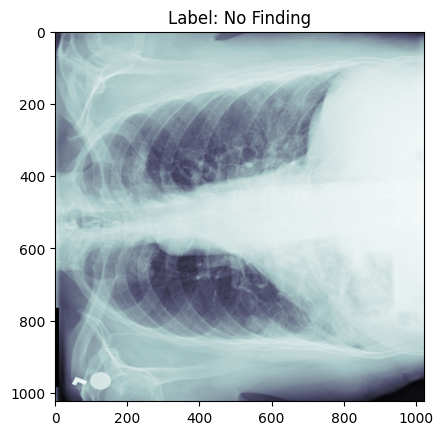

In [30]:
# patient_id = scan._meta["filename_or_obj"].split("/")[-1].split(".")[0]
plt.title(f"Label: {label[0]}")
display_scan = scan.squeeze().numpy()
# display_scan = np.transpose(display_scan, (1, 2, 0))
plt.imshow(display_scan, cmap="bone");

# Using `RTK`

In [31]:
from omegaconf import DictConfig
import logging

# rtk
from rtk import datasets
from rtk.utils import hydra_instantiate

logging.getLogger("rtk.datasets").setLevel(logging.DEBUG)

dataset = datasets.instantiate_image_dataset(
    cfg=cfg, save_metadata=True
)
train_dataset, test_dataset = dataset[0], dataset[1]

[13:46:43] INFO     rtk.datasets: Instantiating image dataset...[0m                                 ]8;id=234053;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py\datasets.py]8;;\:]8;id=146316;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py#624\624]8;;\

[13:46:45] INFO     rtk.datasets: Transforming labels to metaclass...[0m                            ]8;id=571858;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py\datasets.py]8;;\:]8;id=91161;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py#247\247]8;;\

[13:46:46] INFO     rtk.datasets: Labels transformed.                                               ]8;id=229258;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py\datasets.py]8;;\:]8;id=243962;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py#253\253]8;;\
                    [0m                                                                                            

           INFO     rtk.datasets: Labels transformed. New class counts:                             ]8;id=750800;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py\datasets.py]8;;\:]8;id=681453;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py#257\257]8;;\
                    {'No Finding': 60361, 'Pneumonia': 677}.                                                       
                    [0m                                                                                            

           INFO     rtk.datasets: Creating 'train' transforms...[0m                                  ]8;id=617889;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py\datasets.py]8;;\:]8;id=291704;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py#97\97]8;;\

           INFO     rtk.datasets: Creating 'eval' transforms...[0m                                   ]8;id=167414;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py\datasets.py]8;;\:]8;id=732052;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py#99\99]8;;\

           INFO     rtk.datasets: Image dataset instantiated.                                       ]8;id=800581;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py\datasets.py]8;;\:]8;id=352944;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py#648\648]8;;\
                    [0m                                                                                            

In [32]:
train_dataset[0][0].shape

torch.Size([3, 229, 229])

In [33]:
train_loader = hydra_instantiate(
    cfg=dataset_cfg.dataloader,
    dataset=train_dataset,
    pin_memory=torch.cuda.is_available(),
    shuffle=True,
)
test_loader = hydra_instantiate(
    cfg=dataset_cfg.dataloader,
    dataset=test_dataset,
    pin_memory=torch.cuda.is_available(),
)
iterator = iter(train_loader)


## Get some samples

In [34]:
import random

batch_size = dataset_cfg.dataloader.batch_size
idx = random.randint(0, batch_size)
scan, label = next(iterator)
idx, scan.shape, label

(3, torch.Size([16, 3, 229, 229]), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [35]:
_filename = scan[idx]._meta['filename_or_obj'].split('/')[-1]
patient_id = _filename.split('.')[0]
patient_id

'00010718_013'

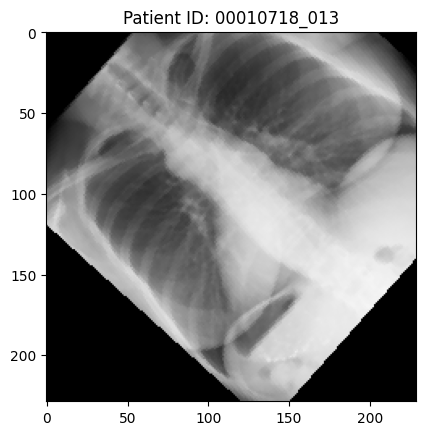

In [36]:
plt.title(f"Patient ID: {patient_id}")
display_scan = scan[0].numpy()
display_scan = np.transpose(display_scan, (1, 2, 0))
plt.imshow(display_scan, cmap="bone");

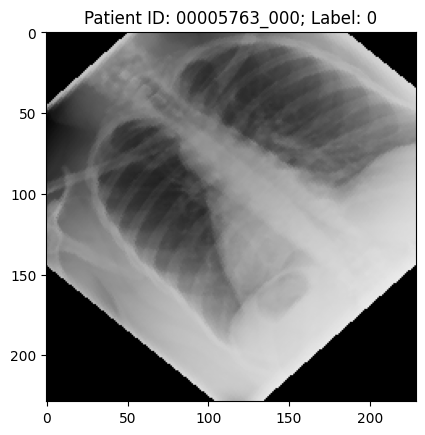

In [37]:
scan, label = datasets.visualize_scan(iterator=iterator)

# Pediatrics age overlap

In [38]:
pneumonia = "Pneumonia"
ped = patient_df[patient_df[target].str.contains(pneumonia)]


ped[ped["Patient Age"] < 18]

,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,image_files
Image Index,,,,,,,,,,,,
00001054_002.png,Atelectasis|Pneumonia,2,1054,13,M,PA,2048,2500,0.171,0.171,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00001255_031.png,Infiltration|Pneumonia,31,1255,13,M,AP,2048,2500,0.171,0.171,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00001855_008.png,Pneumonia,8,1855,12,M,PA,2048,2500,0.168,0.168,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00001855_037.png,Edema|Pneumonia,37,1855,13,M,AP,2048,2500,0.168,0.168,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00001946_007.png,Pneumonia,7,1946,16,M,PA,2992,2991,0.143,0.143,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
...,...,...,...,...,...,...,...,...,...,...,...,...
00030079_018.png,Pneumonia,18,30079,16,M,AP,3056,2544,0.139,0.139,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00030079_022.png,Infiltration|Pneumonia,22,30079,16,M,AP,3056,2544,0.139,0.139,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00030079_066.png,Edema|Infiltration|Pneumonia,66,30079,16,M,AP,3056,2544,0.139,0.139,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...


In [39]:
print(f"Number of patients with {pneumonia}:", len(ped))
print(f"Number of patients with {pneumonia} and age < 18:", len(ped[ped["Patient Age"] < 18]))
print(f"Number of patients with {pneumonia} and age < 21:", len(ped[ped["Patient Age"] < 21]))

Number of patients with Pneumonia: 1431
Number of patients with Pneumonia and age < 18: 108
Number of patients with Pneumonia and age < 21: 136


## Combine Chest XRay and Pediatrics data

In [40]:
dataset_cfg.additional_datasets

{'dataset_configs': [{'filepath': '/home/nicoleg/workspaces/teddytoolkit/configs/datasets/chest-xray-dataset.yaml', 'loader': 'load_chest_xray_dataset'}]}

In [41]:
from rtk.utils import yaml_to_configuration

pediatrics_file_path = dataset_cfg.additional_datasets["dataset_configs"][0]["filepath"]

pediatrics: DatasetConfiguration = yaml_to_configuration(pediatrics_file_path)
pediatrics


{'dim': 384, 'extension': '.jpeg', 'labels': ['NORMAL', 'PNEUMONIA'], 'patient_data': None, 'scan_data': '/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_Images_RGB/', 'encoding': {0: 'NORMAL', 1: 'PNEUMONIA'}, 'instantiate': {'_target_': 'monai.data.ImageDataset'}, 'dataloader': {'_target_': 'monai.data.ThreadDataLoader', 'batch_size': 16, 'num_workers': 24}}

In [42]:
from rtk.datasets import load_chest_xray_dataset

ped_train_dataset, ped_test_dataset, ped_train_metadata, ped_test_metadata = load_chest_xray_dataset(
    cfg=cfg,
    dataset_cfg=pediatrics,
    return_metadata=True,
)
ped_train_metadata_subset = ped_train_metadata[ped_train_metadata["labels"] == 1]
ped_test_metadata_subset = ped_test_metadata[ped_test_metadata["labels"] == 1]
ped_train_metadata_subset

[13:46:52] INFO     rtk.datasets: Creating 'train' transforms...[0m                                  ]8;id=360663;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py\datasets.py]8;;\:]8;id=633052;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py#97\97]8;;\

           INFO     rtk.datasets: Creating 'eval' transforms...[0m                                   ]8;id=481741;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py\datasets.py]8;;\:]8;id=562275;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py#99\99]8;;\

           INFO     rtk.datasets: Building chest x-ray metadata dataframe for split: 'train'...     ]8;id=307419;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py\datasets.py]8;;\:]8;id=869693;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py#376\376]8;;\
                    [0m                                                                                            

           INFO     rtk.datasets: Building chest x-ray metadata dataframe for split: 'test'...      ]8;id=379201;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py\datasets.py]8;;\:]8;id=605397;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py#376\376]8;;\
                    [0m                                                                                            

,image_files,labels
1349,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...,1
1350,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...,1
1351,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...,1
1352,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...,1
1353,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...,1
...,...,...
5227,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...,1
5228,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...,1
5229,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...,1
5230,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...,1


In [43]:
vars(cfg)


{
    'date': '2023-10-18',
    'postfix': '',
    'timestamp': '13-46-41',
    'datasets': {'dim': 229, 'extension': '.png', 'index': 'Image Index', 'labels': ['No Finding', 'Pneumonia'], 'target': 'Finding Labels', 'patient_data': '/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_14_Kaggle_RGB/Data_Entry_2017.csv', 'scan_data': '/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_14_Kaggle_RGB/', 'encoding': {'No Finding': 0, 'Pneumonia': 1}, 'instantiate': {'_target_': 'monai.data.ImageDataset'}, 'dataloader': {'_target_': 'monai.data.ThreadDataLoader', 'batch_size': 16, 'num_workers': 24}, 'additional_datasets': {'dataset_configs': [{'filepath': '/home/nicoleg/workspaces/teddytoolkit/configs/datasets/chest-xray-dataset.yaml', 'loader': 'load_chest_xray_dataset'}]}, 'preprocessing': {'subset': ['Atelectasis', 'Edema', 'Effusion', 'Consolidation', 'Pneumonia'], 'use_sampling': True, 'sampling_method': {'sample_to_value': 5000, 'method': {'_partial_': True, '_target_': 'imbl

In [44]:
combined_train_dataset = deepcopy(train_dataset)
combined_test_dataset = deepcopy(test_dataset)
combined_train_dataset.image_files


array(['/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_14_Kaggle_RGB/00000002_000.png',
       '/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_14_Kaggle_RGB/00000005_000.png',
       '/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_14_Kaggle_RGB/00000005_001.png',
       ...,
       '/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_14_Kaggle_RGB/00030770_002.png',
       '/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_14_Kaggle_RGB/00030772_000.png',
       '/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_14_Kaggle_RGB/00030801_000.png'],
      dtype=object)

In [45]:
combined_train_image_files = np.hstack((ped_train_metadata_subset.image_files.values, train_dataset.image_files))
combined_test_image_files = np.hstack((ped_test_metadata_subset.image_files.values, test_dataset.image_files))
combined_train_labels = np.hstack((ped_train_metadata_subset.labels.values, train_dataset.labels))
combined_test_labels = np.hstack((ped_test_metadata_subset.labels.values, test_dataset.labels))


In [46]:
from rtk.utils import hydra_instantiate

combined_train_dataset = hydra_instantiate(
    cfg=dataset_cfg.instantiate,
    image_files=combined_train_image_files,
    labels=combined_train_labels,
    transform=train_dataset.transform,
)
combined_test_dataset = hydra_instantiate(
    cfg=dataset_cfg.instantiate,
    image_files=combined_test_image_files,
    labels=combined_test_labels,
    transform=test_dataset.transform,
)
combined_train_dataset

In [47]:
from collections import Counter

Counter(train_dataset.labels), Counter(combined_train_dataset.labels)

(Counter({0: 50500, 1: 449}), Counter({1: 4332, 0: 50500}))

In [48]:
Counter(test_dataset.labels), Counter(combined_test_dataset.labels)

(Counter({0: 9861, 1: 228}), Counter({1: 618, 0: 9861}))

In [49]:
from rtk.datasets import combine_datasets

combined_train_dataset, combined_test_dataset = combine_datasets(train_dataset, test_dataset, dataset_cfg=dataset_cfg)
# combined_test_dataset = combine_datasets(test_dataset, ped_test_dataset, dataset_cfg=dataset_cfg, transform=test_dataset.transform)
combined_train_dataset.image_files

           INFO     rtk.datasets: Adding addtional datasets...[0m                                   ]8;id=238968;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py\datasets.py]8;;\:]8;id=810620;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py#894\894]8;;\

           INFO     rtk.datasets: Adding additional dataset: 'chest-xray-dataset'...[0m             ]8;id=105907;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py\datasets.py]8;;\:]8;id=398591;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py#915\915]8;;\

           INFO     rtk.datasets: Creating 'train' transforms...[0m                                  ]8;id=382554;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py\datasets.py]8;;\:]8;id=170555;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py#97\97]8;;\

           INFO     rtk.datasets: Creating 'eval' transforms...[0m                                   ]8;id=279946;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py\datasets.py]8;;\:]8;id=735911;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py#99\99]8;;\

           INFO     rtk.datasets: Building chest x-ray metadata dataframe for split: 'train'...     ]8;id=638720;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py\datasets.py]8;;\:]8;id=665822;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py#376\376]8;;\
                    [0m                                                                                            

           INFO     rtk.datasets: Building chest x-ray metadata dataframe for split: 'test'...      ]8;id=171339;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py\datasets.py]8;;\:]8;id=484714;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py#376\376]8;;\
                    [0m                                                                                            

           INFO     rtk.datasets: Additional datasets added.[0m                                     ]8;id=584004;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py\datasets.py]8;;\:]8;id=230283;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py#965\965]8;;\

           INFO     rtk.datasets: Train dataset:    Counter({0: 50500, 1: 4332})[0m                 ]8;id=58655;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py\datasets.py]8;;\:]8;id=240174;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py#966\966]8;;\

           INFO     rtk.datasets: Test dataset:     Counter({0: 9861, 1: 618})                      ]8;id=280746;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py\datasets.py]8;;\:]8;id=69403;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py#967\967]8;;\
                    [0m                                                                                            


array(['/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_14_Kaggle_RGB/00000002_000.png',
       '/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_14_Kaggle_RGB/00000005_000.png',
       '/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_14_Kaggle_RGB/00000005_001.png',
       ...,
       '/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_Images_RGB/train/PNEUMONIA/BACTERIA-6443888-0003.jpeg',
       '/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_Images_RGB/train/PNEUMONIA/BACTERIA-5608291-0001.jpeg',
       '/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_Images_RGB/train/PNEUMONIA/BACTERIA-9364407-0002.jpeg'],
      dtype=object)

In [50]:
len(combined_train_dataset.image_files)

54832

In [51]:
combined_train_dataloader = hydra_instantiate(
    cfg=dataset_cfg.dataloader,
    dataset=combined_train_dataset,
    pin_memory=torch.cuda.is_available(),
    shuffle=True,
)
combined_test_dataloader = hydra_instantiate(
    cfg=dataset_cfg.dataloader,
    dataset=combined_test_dataset,
    pin_memory=torch.cuda.is_available(),
    shuffle=True,
)
combined_train_iterator = iter(combined_train_dataloader)
combined_test_iterator = iter(combined_test_dataloader)


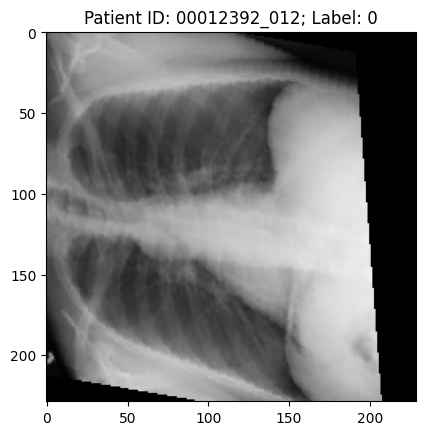

In [54]:
scan, label = datasets.visualize_scan(iterator=combined_train_iterator)

In [55]:
combined_train_dataset.image_files


array(['/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_14_Kaggle_RGB/00000002_000.png',
       '/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_14_Kaggle_RGB/00000005_000.png',
       '/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_14_Kaggle_RGB/00000005_001.png',
       ...,
       '/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_Images_RGB/train/PNEUMONIA/BACTERIA-6443888-0003.jpeg',
       '/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_Images_RGB/train/PNEUMONIA/BACTERIA-5608291-0001.jpeg',
       '/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_Images_RGB/train/PNEUMONIA/BACTERIA-9364407-0002.jpeg'],
      dtype=object)

## with RTK

In [56]:
Counter(train_dataset.labels), Counter(test_dataset.labels)


(Counter({0: 50500, 1: 449}), Counter({0: 9861, 1: 228}))

In [57]:
train_dataset, test_dataset = datasets.combine_datasets(train_dataset, test_dataset, dataset_cfg=dataset_cfg)

Counter(train_dataset.labels), Counter(test_dataset.labels)


[13:48:10] INFO     rtk.datasets: Adding addtional datasets...[0m                                   ]8;id=958972;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py\datasets.py]8;;\:]8;id=674079;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py#894\894]8;;\

           INFO     rtk.datasets: Adding additional dataset: 'chest-xray-dataset'...[0m             ]8;id=258607;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py\datasets.py]8;;\:]8;id=781177;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py#915\915]8;;\

           INFO     rtk.datasets: Creating 'train' transforms...[0m                                  ]8;id=612982;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py\datasets.py]8;;\:]8;id=449245;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py#97\97]8;;\

           INFO     rtk.datasets: Creating 'eval' transforms...[0m                                   ]8;id=229974;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py\datasets.py]8;;\:]8;id=145051;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py#99\99]8;;\

           INFO     rtk.datasets: Building chest x-ray metadata dataframe for split: 'train'...     ]8;id=49405;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py\datasets.py]8;;\:]8;id=902931;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py#376\376]8;;\
                    [0m                                                                                            

           INFO     rtk.datasets: Building chest x-ray metadata dataframe for split: 'test'...      ]8;id=830555;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py\datasets.py]8;;\:]8;id=713536;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py#376\376]8;;\
                    [0m                                                                                            

           INFO     rtk.datasets: Additional datasets added.[0m                                     ]8;id=400156;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py\datasets.py]8;;\:]8;id=624834;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py#965\965]8;;\

           INFO     rtk.datasets: Train dataset:    Counter({0: 50500, 1: 4332})[0m                 ]8;id=902592;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py\datasets.py]8;;\:]8;id=988210;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py#966\966]8;;\

           INFO     rtk.datasets: Test dataset:     Counter({0: 9861, 1: 618})                      ]8;id=714825;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py\datasets.py]8;;\:]8;id=927767;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py#967\967]8;;\
                    [0m                                                                                            

(Counter({0: 50500, 1: 4332}), Counter({0: 9861, 1: 618}))